# NYC Taxi Trip Duration Prediction

This notebook demonstrates a ML pipeline for predicting taxi trip durations using NYC Yellow Taxi data from October-November 2023.

## Pipeline Steps
1. Data preprocessing (using separate script)
2. Model training
3. Model evaluation
4. Results visualization

In [4]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:
# import sys
# print(sys.executable)

### 1. Downloading the data



In [7]:
# check different datasets:  https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-10.parquet')

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-10-01 00:16:44,2023-10-01 00:16:49,1.0,0.00,1.0,N,168,168,2,3.0,1.0,0.5,0.0,0.0,1.0,5.5,0.0,0.0
1,1,2023-10-01 00:23:24,2023-10-01 00:23:47,1.0,0.00,1.0,N,168,168,2,3.0,1.0,0.5,0.0,0.0,1.0,5.5,0.0,0.0
2,1,2023-10-01 00:21:18,2023-10-01 00:27:31,1.0,0.90,1.0,N,161,186,1,6.5,3.5,0.5,2.9,0.0,1.0,14.4,2.5,0.0
3,1,2023-10-01 00:17:39,2023-10-01 00:17:47,0.0,0.00,1.0,N,255,255,3,3.0,1.0,0.5,0.0,0.0,1.0,5.5,0.0,0.0
4,2,2023-10-01 00:16:15,2023-10-01 00:22:57,2.0,1.41,1.0,N,151,239,1,10.0,1.0,0.5,3.0,0.0,1.0,18.0,2.5,0.0


In [10]:
len(df.columns)

19

### 2. Computing duration

In [11]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [12]:
df.duration.mean()

10.275359962827165

In [13]:
df.duration.std()

15051.56798201876

### 3. Dropping outliers

In [14]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

96.889519161567

In [15]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

### 4. One-hot encoding

In [16]:
categorical = ['PULocationID', 'DOLocationID']

In [17]:
df[categorical] = df[categorical].astype(str)

In [18]:
train_dicts = df[categorical].to_dict(orient='records')

In [19]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [20]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3412725, 513)


### 5. Training a model

In [21]:
target = 'duration'
y_train = df[target].values

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred)}')

Train RMSE: 82.03465048075427


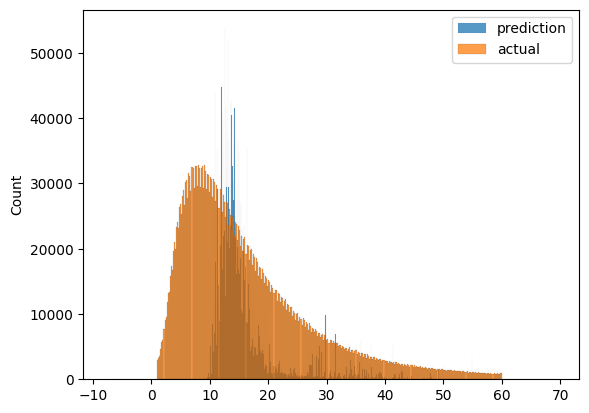

In [25]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

### 6. Evaluating the model

In [26]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [28]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-11.parquet')

In [29]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [30]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [31]:
y_pred = lr.predict(X_val)

In [33]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred)}')

Val RMSE: 82.20109399366713
